In [1]:
#importing the libraries
import numpy as np #for mathematical calculations
import cv2 #for face detection and other image operations
import dlib #for detection of facial landmarks ex:nose,jawline,eyes
from sklearn.cluster import KMeans #for clustering
from matplotlib import pyplot as plt

#load the image
imagepath = "./INPUT/C7.jpg"
#haarcascade for detecting faces
# link = https://github.com/opencv/opencv/tree/master/data/haarcascades
face_cascade_path = "./haarcascade_frontalface_default.xml"
#.dat file for detecting facial landmarks
#download file path = http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
predictor_path = "./shape_predictor_68_face_landmarks.dat"

#create the haar cascade for detecting face and smile
faceCascade = cv2.CascadeClassifier(face_cascade_path)

#create the landmark predictor
predictor = dlib.shape_predictor(predictor_path)

#read the image
image = cv2.imread(imagepath)

#resizing the image to 000 cols nd 500 rows
image = cv2.resize(image, (500, 500)) 
#making another copy
original = image.copy()

#convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#apply a Gaussian blur with a 3 x 3 kernel to help remove high frequency noise
gauss = cv2.GaussianBlur(gray,(3,3), 0)

#Detect faces in the image
faces = faceCascade.detectMultiScale(
    gauss,
    scaleFactor=1.05,
    minNeighbors=5,
    minSize=(100,100),
    flags=cv2.CASCADE_SCALE_IMAGE
    )
#Detect faces in the image
print("found {0} faces!".format(len(faces)) )

for (x,y,w,h) in faces:
    #draw a rectangle around the faces
    cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0), 2)
    #converting the opencv rectangle coordinates to Dlib rectangle
    dlib_rect = dlib.rectangle(int(x), int(y), int(x+w), int(y+h))
    #detecting landmarks
    detected_landmarks = predictor(image, dlib_rect).parts()
    #converting to np matrix
    landmarks = np.matrix([[p.x,p.y] for p in detected_landmarks])
    #landmarks array contains indices of landmarks.
    """
    #copying the image so we can we side by side
    landmark = image.copy()
    for idx, point in enumerate(landmarks):
            pos = (point[0,0], point[0,1] )
            #annotate the positions
            cv2.putText(landmark,str(idx),pos,fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=0.4,color=(0,0,255) )
            #draw points on the landmark positions 
            cv2.circle(landmark, pos, 3, color=(0,255,255))
    
cv2.imshow("Landmarks by DLib", landmark)
"""
#making another copy  for showing final results
results = original.copy()

for (x,y,w,h) in faces:
    #draw a rectangle around the faces
    cv2.rectangle(results, (x,y), (x+w,y+h), (0,255,0), 2)
    #making temporary copy
    temp = original.copy()
    #getting area of interest from image i.e., forehead (25% of face)
    forehead = temp[y:y+int(0.25*h), x:x+w]
    rows,cols, bands = forehead.shape
    X = forehead.reshape(rows*cols,bands)
    """
    Applying kmeans clustering algorithm for forehead with 2 clusters 
    this clustering differentiates between hair and skin (thats why 2 clusters)
    """
    #kmeans
    kmeans = KMeans(n_clusters=2,init='k-means++',max_iter=300,n_init=10, random_state=0)
    y_kmeans = kmeans.fit_predict(X)
    for i in range(0,rows):
        for j in range(0,cols):
            if y_kmeans[i*cols+j]==True:
                forehead[i][j]=[255,255,255]
            if y_kmeans[i*cols+j]==False:
                forehead[i][j]=[0,0,0]
    #Steps to get the length of forehead
    #1.get midpoint of the forehead
    #2.travel left side and right side
    #the idea here is to detect the corners of forehead which is the hair.
    #3.Consider the point which has change in pixel value (which is hair)
    forehead_mid = [int(cols/2), int(rows/2) ] #midpoint of forehead
    lef=0 
    #gets the value of forehead point
    pixel_value = forehead[forehead_mid[1],forehead_mid[0] ]
    for i in range(0,cols):
        #enters if when change in pixel color is detected
        if forehead[forehead_mid[1],forehead_mid[0]-i].all()!=pixel_value.all():
            lef=forehead_mid[0]-i
            break;
    left = [lef,forehead_mid[1]]
    rig=0
    for i in range(0,cols):
        #enters if when change in pixel color is detected
        if forehead[forehead_mid[1],forehead_mid[0]+i].all()!=pixel_value.all():
            rig = forehead_mid[0]+i
            break;
    right = [rig,forehead_mid[1]]
    
#drawing line1 on forehead with circles
#specific landmarks are used. 
line1 = np.subtract(right+y,left+x)[0]
cv2.line(results, tuple(x+left), tuple(y+right), color=(0,255,0), thickness = 2)
cv2.putText(results,' Line 1',tuple(x+left),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(0,255,0), thickness=2)
cv2.circle(results, tuple(x+left), 5, color=(255,0,0), thickness=-1)    
cv2.circle(results, tuple(y+right), 5, color=(255,0,0), thickness=-1)        

#drawing line 2 with circles
linepointleft = (landmarks[1,0],landmarks[1,1])
linepointright = (landmarks[15,0],landmarks[15,1])
line2 = np.subtract(linepointright,linepointleft)[0]
cv2.line(results, linepointleft,linepointright,color=(0,255,0), thickness = 2)
cv2.putText(results,' Line 2',linepointleft,fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(0,255,0), thickness=2)
cv2.circle(results, linepointleft, 5, color=(255,0,0), thickness=-1)    
cv2.circle(results, linepointright, 5, color=(255,0,0), thickness=-1)    

#drawing line 3 with circles
linepointleft = (landmarks[3,0],landmarks[3,1])
linepointright = (landmarks[13,0],landmarks[13,1])
line3 = np.subtract(linepointright,linepointleft)[0]
cv2.line(results, linepointleft,linepointright,color=(0,255,0), thickness = 2)
cv2.putText(results,' Line 3',linepointleft,fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(0,255,0), thickness=2)
cv2.circle(results, linepointleft, 5, color=(255,0,0), thickness=-1)    
cv2.circle(results, linepointright, 5, color=(255,0,0), thickness=-1)    

#drawing line 4 with circles
linepointbottom = (landmarks[8,0],landmarks[8,1])
linepointtop = (landmarks[8,0],y)
line4 = np.subtract(linepointbottom,linepointtop)[1]
cv2.line(results,linepointtop,linepointbottom,color=(0,255,0), thickness = 2)
cv2.putText(results,' Line 4',linepointbottom,fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(0,255,0), thickness=2)
cv2.circle(results, linepointtop, 5, color=(255,0,0), thickness=-1)    
cv2.circle(results, linepointbottom, 5, color=(255,0,0), thickness=-1)    
#print(line1,line2,line3,line4)

similarity = np.std([line1,line2,line3])
#print("similarity=",similarity)
ovalsimilarity = np.std([line2,line4])
#print('diam=',ovalsimilarity)

#we use arcustangens for angle calculation
ax,ay = landmarks[3,0],landmarks[3,1]
bx,by = landmarks[4,0],landmarks[4,1]
cx,cy = landmarks[5,0],landmarks[5,1]
dx,dy = landmarks[6,0],landmarks[6,1]
import math
from math import degrees
alpha0 = math.atan2(cy-ay,cx-ax)
alpha1 = math.atan2(dy-by,dx-bx)
alpha = alpha1-alpha0
angle = abs(degrees(alpha))
angle = 180-angle


for i in range(1):
    if similarity<10:
        if angle<160:
            print('squared shape.Jawlines are more angular')
            break
        else:
            print('round shape.Jawlines are not that angular')
            break
    if line3>line1:
        if angle<160:
            print('triangle shape.Forehead is more wider') 
            break
            
    if ovalsimilarity<10:
        print('diamond shape. line2 & line4 are similar and line2 is slightly larger')
        break
    if line4 > line2:
        if angle<160:
            print('rectangular. face length is largest and jawline are angular ')
            break;
        else:
            print('oblong. face length is largest and jawlines are not angular')
            break;
        
    print("Damn! Contact the developer")

#output = np.concatenate((original,results), axis=1)
#cv2.imshow('output',output)

found 1 faces!
oblong. face length is largest and jawlines are not angular


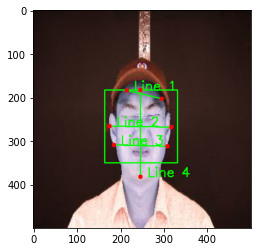

In [4]:
from matplotlib import pyplot as plt

output = np.concatenate((original,results), axis=1)

plt.imshow(results)
#plt.show()
plt.savefig("./output.png")

In [3]:
#  Necessary import
import cv2
import dlib
import numpy as np
import os
import imutils

In [4]:
#  Set the directory 
path = './INPUT/'
#  Initialize color  [color_type] = (Blue, Green, Red)
color_blue = (239,207,137)
color_cyan = (255,200,0)
color_black = (0, 0, 0)

In [5]:
#  Load the image and size it , Convert it to grayscale 
img= cv2.imread('./INPUT/C7.jpg')
img = imutils.resize(img, width = 500)
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [6]:
#  initialization dlib Face detector 
detector = dlib.get_frontal_face_detector()
"""
Detect faces in grayscale images and create an object - Stores a list of coordinates for the bounding rectangle
In the second parameter “1” Indicates that the image should be sampled up 1 Time . 
This makes the image bigger , And allow us to detect more faces
"""
faces = detector(gray, 1)
#  Print the coordinates of the bounding rectangle 
print(faces)
print("Number of faces detected: ", len(faces))
"""
#  Use for Loop to extract specific coordinates (x1,x2,y1,y2)
for face in faces:
  x1 = face.left()
  y1 = face.top()
  x2 = face.right()
  y2 = face.bottom()
  #  Draw a rectangle around the detected face
  cv2.rectangle(img, (x1,y1), (x2,y2),(0,255,0),3)
cv2.imshow("image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()
"""

rectangles[[(182, 125) (311, 254)]]
Number of faces detected:  1


'\n#  Use for Loop to extract specific coordinates (x1,x2,y1,y2)\nfor face in faces:\n  x1 = face.left()\n  y1 = face.top()\n  x2 = face.right()\n  y2 = face.bottom()\n  #  Draw a rectangle around the detected face\n  cv2.rectangle(img, (x1,y1), (x2,y2),(0,255,0),3)\ncv2.imshow("image", img)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n'

In [7]:
#  File path 
p = "shape_predictor_68_face_landmarks.dat"
#  initialization dlib Predictor of 
predictor = dlib.shape_predictor(p)
#  Use predictors to get shapes 
for face in faces:
    landmarks = predictor(gray, face)
    # for n in range(0,68):
    #     x = landmarks.part(n).x
    #     y = landmarks.part(n).y
    #     img_landmark = cv2.circle(img, (x, y), 4, (0, 0, 255), -1)

In [8]:
points = []
for i in range(1, 16):
    point = [landmarks.part(i).x, landmarks.part(i).y]
    points.append(point)
    
    # print(points).
    #  wide , High coverage masks 
    mask_a = [((landmarks.part(42).x), (landmarks.part(15).y)),
              ((landmarks.part(27).x), (landmarks.part(27).y)),
              ((landmarks.part(39).x), (landmarks.part(1).y))]
    #  wide , In the middle of the mask 
    mask_c = [((landmarks.part(29).x), (landmarks.part(29).y))]
    #  wide 、 Low coverage masks 
    mask_e = [((landmarks.part(35).x), (landmarks.part(35).y)),
              ((landmarks.part(34).x), (landmarks.part(34).y)),
              ((landmarks.part(33).x), (landmarks.part(33).y)),
              ((landmarks.part(32).x), (landmarks.part(32).y)),
              ((landmarks.part(31).x), (landmarks.part(31).y))]
    fmask_a = points + mask_a
    fmask_c = points + mask_c
    fmask_e = points + mask_e
    # mask_type = {1: fmask_a, 2: fmask_c, 3: fmask_e}
    # mask_type[choice2]
    #  Use Python OpenCV - cv2.polylines() Method is [mask_type] Draw the mask outline :
    # fmask_a = wide, high coverage mask,
    # fmask_c = wide, medium coverage mask,
    # fmask_e  = wide, low coverage mask
    fmask_a = np.array(fmask_a, dtype=np.int32)
    fmask_c = np.array(fmask_c, dtype=np.int32)
    fmask_e = np.array(fmask_e, dtype=np.int32)
    mask_type = {1: fmask_a, 2: fmask_c, 3: fmask_e}
    mask_type[choice2]
    #  Change parameters [mask_type] and color_type For various combinations 
    img2 = cv2.polylines(img, [mask_type[choice2]], True, choice1, thickness=2, lineType=cv2.LINE_8)
    #  Use Python OpenCV - cv2.fillPoly() How to fill the mask 
    #  Change parameters [mask_type] and color_type For various combinations 
    img3 = cv2.fillPoly(img2, [mask_type[choice2]], choice1, lineType=cv2.LINE_AA)
# cv2.imshow("image with mask outline", img2)
cv2.imshow("image with mask", img3)
#  Save the output file for the test 
outputNameofImage = "imagetest.jpg"
print("Saving output image to", outputNameofImage)
cv2.imwrite(outputNameofImage, img3)

NameError: name 'choice2' is not defined

In [10]:
faces

rectangles[[(182, 125) (311, 254)]]

In [29]:
len(landmarks.parts())

In [30]:
#  Use input() Function to obtain the mask type and mask color according to user needs 
choice1 = input("Please select the choice of mask color\nEnter 1 for blue\nEnter 2 for black:\n")
choice1 = int(choice1)
if choice1 == 1:
    choice1 = color_blue
    print('You selected mask color = blue')
elif choice1 == 2:
    choice1 = color_black
    print('You selected mask color = black')
else:
    print("invalid selection, please select again.")
    input("Please select the choice of mask color\nEnter 1 for blue\nEnter 2 for black :\n")
choice2 = input("Please enter choice of mask type coverage \nEnter 1 for high \nEnter 2 for medium \nEnter 3 for low :\n")
choice2 = int(choice2)
if choice2 == 1:
    # choice2 = fmask_a
    print(f'You chosen wide, high coverage mask')
elif choice2 == 2:
    # choice2 = fmask_c
    print(f'You chosen wide, medium coverage mask')
elif choice2 == 3:
    # choice2 = fmask_e
    print(f'You chosen wide, low coverage mask')
else:
    print("invalid selection, please select again.")
    input("Please enter choice of mask type coverage \nEnter 1 for high \nEnter 2 for medium \nEnter 3 for low :\n")
# print(choice2)

Please select the choice of mask color
Enter 1 for blue
Enter 2 for black:
 1


You selected mask color = blue


Please enter choice of mask type coverage 
Enter 1 for high 
Enter 2 for medium 
Enter 3 for low :
 1


You chosen wide, high coverage mask
